In [5]:
import h5py

def print_hdf5_structure(file_path):
    def print_group(group, indent=0):
        for key in group.keys():
            item = group[key]
            print("  " * indent + f"{key}: {type(item)}")
            if isinstance(item, h5py.Group):
                print_group(item, indent + 1)
            elif isinstance(item, h5py.Dataset):
                print("  " * (indent + 1) + f"Shape: {item.shape}, Dtype: {item.dtype}")

    with h5py.File(file_path, 'r') as f:
        print_group(f)

if __name__ == "__main__":
    file_path = "/root/onolab/catkin_ws/src/gello_software/gello_ros/scripts/episode_data/20241201_102702_cup_in_and_push/episode_0.hdf5"
    print_hdf5_structure(file_path)

action: <class 'h5py._hl.dataset.Dataset'>
  Shape: (1000, 6), Dtype: float32
observations: <class 'h5py._hl.group.Group'>
  images: <class 'h5py._hl.group.Group'>
    base_rgb: <class 'h5py._hl.dataset.Dataset'>
      Shape: (1000, 480, 640, 3), Dtype: uint8
    side_rgb: <class 'h5py._hl.dataset.Dataset'>
      Shape: (1000, 480, 640, 3), Dtype: uint8
  qpos: <class 'h5py._hl.dataset.Dataset'>
    Shape: (1000, 6), Dtype: float32
  qvel: <class 'h5py._hl.dataset.Dataset'>
    Shape: (1000, 6), Dtype: float32
  wrench: <class 'h5py._hl.dataset.Dataset'>
    Shape: (1000, 6), Dtype: float32


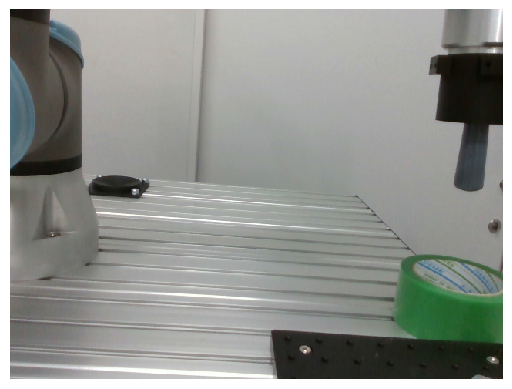

In [6]:
import matplotlib.pyplot as plt

def display_image_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        image_data = f['observations/images/base_rgb']
        
        # Display the first image in the dataset
        plt.imshow(image_data[500])
        plt.axis('off')  # Hide the axis
        plt.show()

display_image_from_hdf5(file_path)

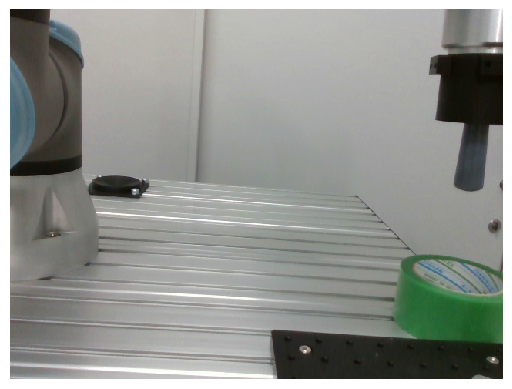

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def display_video_from_hdf5(file_path, start_index, end_index, interval=50):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        image_data = f['observations/images/base_rgb']
        
        # Create a figure and axis for displaying the images
        fig, ax = plt.subplots()
        ax.axis('off')  # Hide the axis
        
        # Create an empty image object to update during animation
        im = ax.imshow(image_data[start_index], animated=True)
        
        # Function to update the frame for the animation
        def update_frame(frame):
            rgb_image = image_data[start_index + frame]
            im.set_array(rgb_image)
            return [im]
        
        # Create the animation
        ani = animation.FuncAnimation(fig, update_frame, frames=end_index - start_index, interval=interval, blit=True)
        
        # Display the animation in Jupyter as HTML
        return HTML(ani.to_jshtml())

# Usage example:
start_index = 7  # Start frame
end_index =  15   # End frame
display_video_from_hdf5(file_path, start_index, end_index)


## Test DETR with COCO classes

In [8]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [9]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [10]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [11]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Detection - using a pre-trained model from TorchHub

In this section, we show-case how to load a model from hub, run it on a custom image, and print the result.
Here we load the simplest model (DETR-R50) for fast inference. You can swap it with any other model from the model zoo.

In [12]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


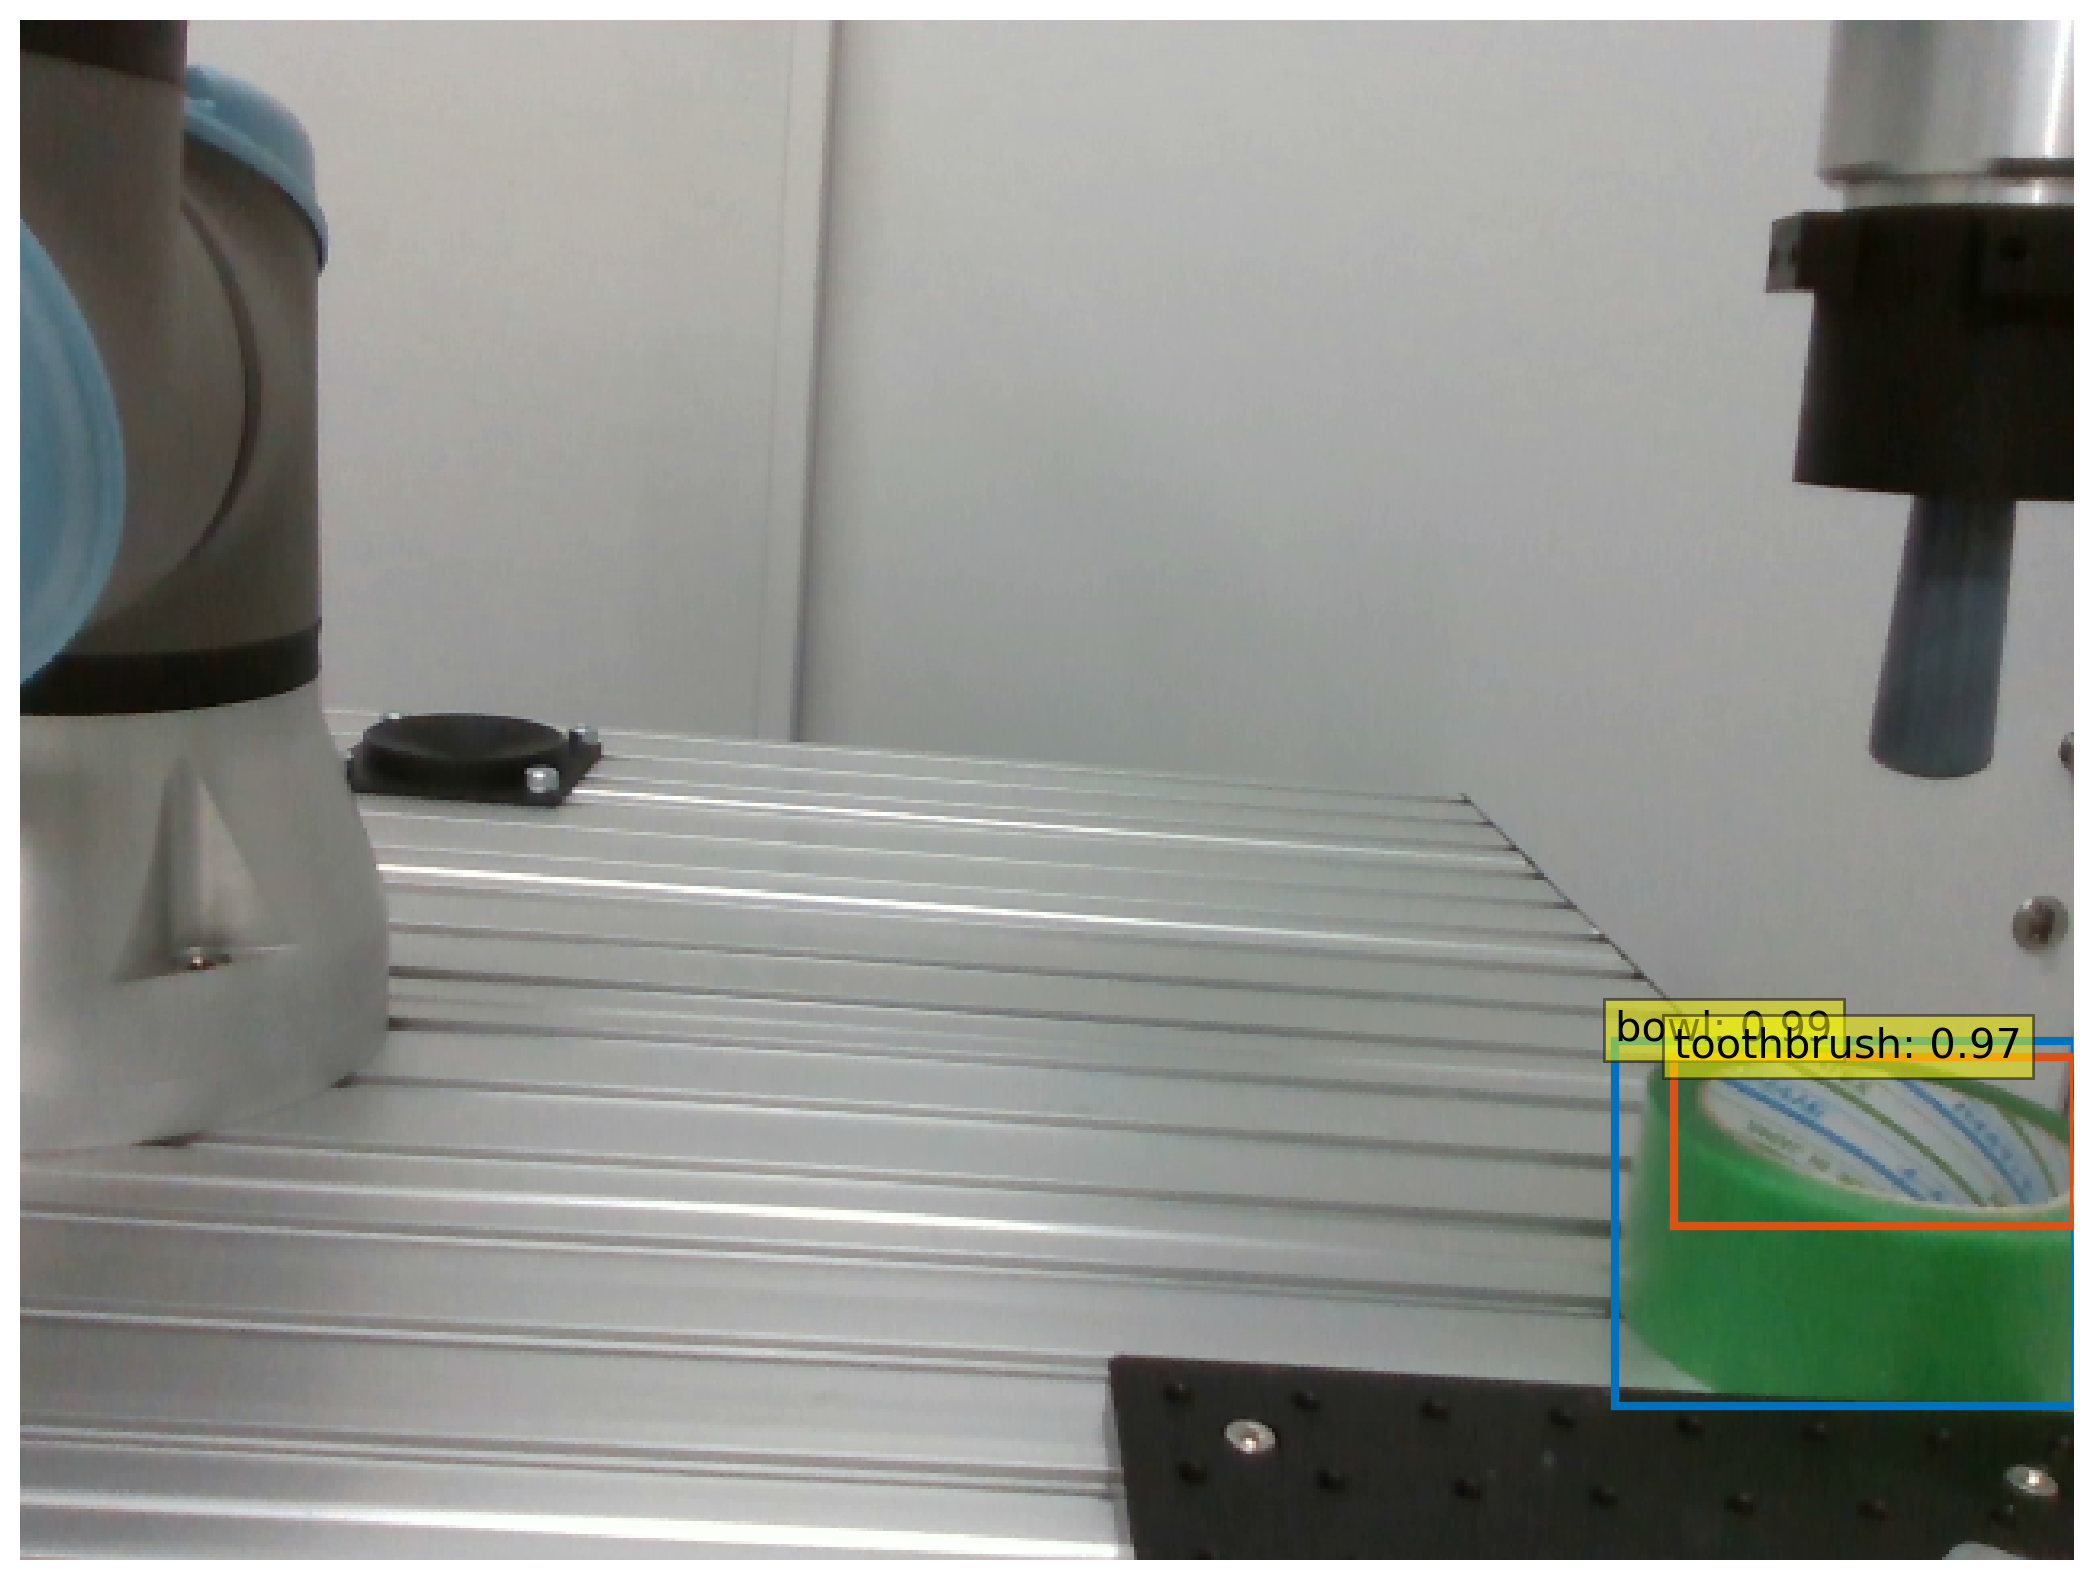

In [14]:
with h5py.File(file_path, 'r') as f:
        image_data = f['observations/images/base_rgb']
        im_np=image_data[500]
im = Image.fromarray(np.uint8(im_np))

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
plot_results(im, probas[keep], bboxes_scaled)